# Functional Metaribo-seq Analysis

This notebook performs a functional analysis of the meta-riboseq soil sample.

Data used in this notebook is produced by `ko_analysis.py`.

### Workflow:
- Preliminary alignment assessments (gene coverage, functional term distributions)
- Comparison of functional term proportions between species
- Breakdown of top functional terms using both raw counts and an aggregated GSEA metric (more details in `functional_analysis_tools.py`)

***

In [ ]:
import sys
from pathlib import Path

root = Path.cwd().parent
sys.path.append(str(root))

In [3]:
import random
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skbio.stats.ordination import pcoa
from sklearn.metrics.pairwise import pairwise_distances

from src import func_utils

In [ ]:
#all gene alignment counts
gcts = r'raw_data\go_analysis\raw_counts\agg\counts_agg.tsv'

In [ ]:
#binned KO and KEGG Pathway counts
agg_ko = r'raw_data\go_analysis\combined_ko\ko_counts.tsv'
agg_pathway =  r'raw_data\go_analysis\combined_pathway\pathway_counts.tsv'

In [ ]:
#gsea results and raw counts directories
ko_gsea_path = r'raw_data\go_analysis\ssgsea_res\ko_gsea'
path_gsea_path = r'raw_data\go_analysis\ssgsea_res\pathway_gsea'
ko_raw_path = r'raw_data\go_analysis\raw_counts\raw_spcts_ko'
pathway_raw_path = r'raw_data\go_analysis\raw_counts\raw_spcts_kp'

In [ ]:
ko_counts_df = pd.read_csv(agg_ko, sep = '\t')

path_counts_df = pd.read_csv(agg_pathway, sep = '\t')

fcounts = (('KO term', ko_counts_df) , 
          ('KEGG Pathway term', path_counts_df))

In [ ]:
#standardize column names
ko_counts_df.rename(columns={'KO': 'pathway', 'count': 'enrichment'}, inplace = True)
path_counts_df.rename(columns={'count':'enrichment'}, inplace = True)

In [ ]:
# merge subgroups of pathways
path_counts_df['pathway'] = path_counts_df['pathway'].str.split(' - ').str[0]
path_counts_df = path_counts_df.groupby('pathway', as_index=False)['count'].sum()

KeyError: 'Column not found: count'

In [ ]:
gcts_df = pd.read_csv(gcts, sep='\t', header = 0, dtype={'gene': str, 'count': float})

## Preliminary analysis

In [ ]:
#gene coverage 
gcts_df_nonzero = gcts_df[gcts_df['count'] > 0]
np.log_counts = np.log10(gcts_df_nonzero['count'])
np.log_counts.plot(kind='hist', bins=50)
plt.xlabel('log(count)')
plt.title('Aggregated footprint coverage across genes')
plt.savefig('figures/functional_analysis/agg_gcts.png')
plt.show()

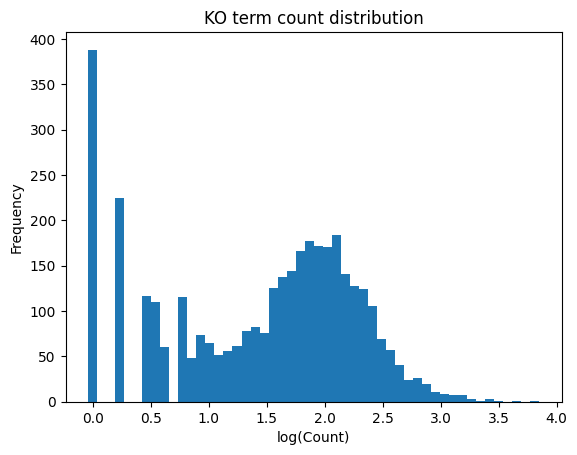

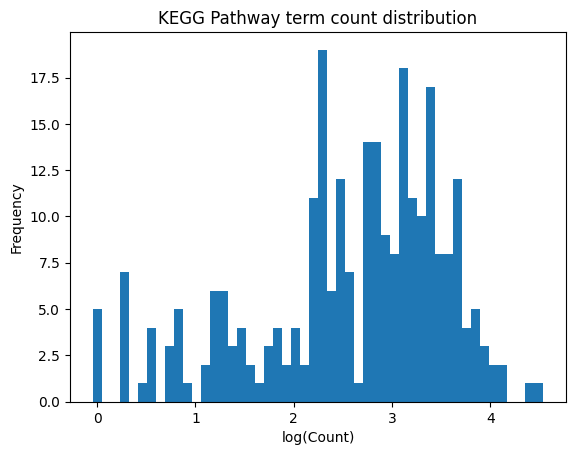

In [ ]:
#functional term distributions. should follow a roughly log-normal distribution.
for name, df in fcounts:
    positive_counts = df[df['count'] > 0]['count']

    log_counts = np.log10(positive_counts)

    min_val, max_val = log_counts.min(), log_counts.max()

    counts, bin_edges = np.histogram(log_counts, bins=50, range=[min_val, max_val])

    plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges))
    plt.xlabel('log(Count)')
    plt.ylabel('Frequency')
    plt.title(f'{name} count distribution')
    plt.savefig(f'figures/functional_analysis/log10_distribution_{'_'.join(name.lower().split(' '))}_counts.png')
    plt.show()


## Functional term comparison

C:\Users\yoche\AppData\Local\Temp\ipykernel_37308\4175513190.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'uNkOM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bac_df.loc[mask, term_col] = rand_str
C:\Users\yoche\AppData\Local\Temp\ipykernel_37308\4175513190.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ardqv' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bac_df.loc[mask, term_col] = rand_str


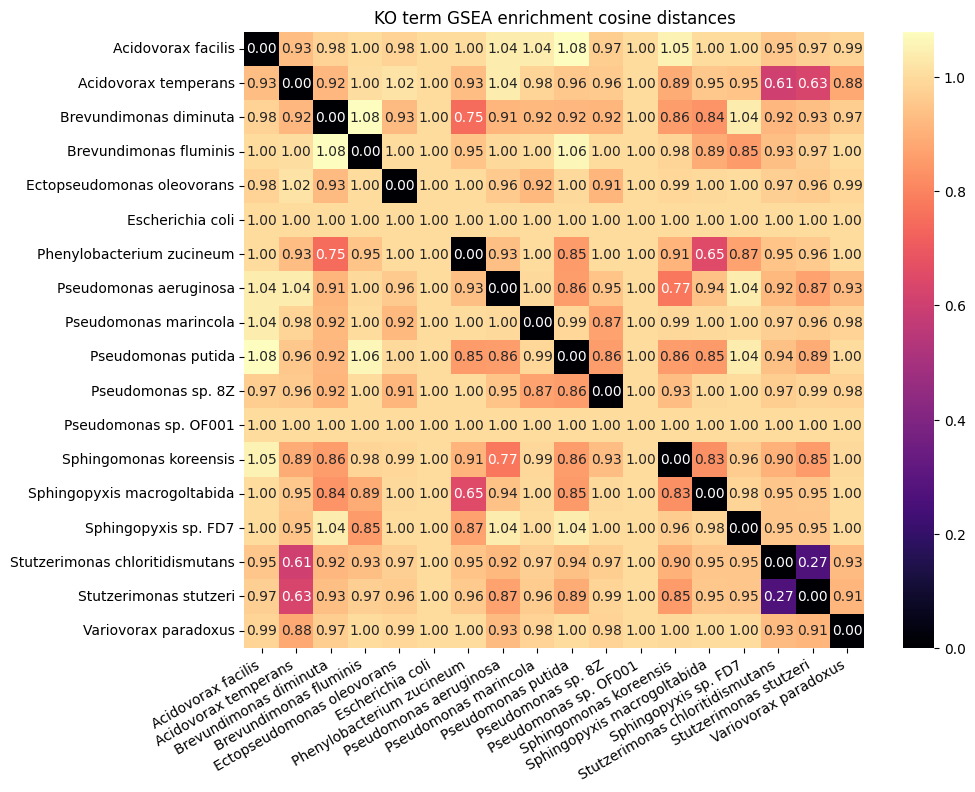

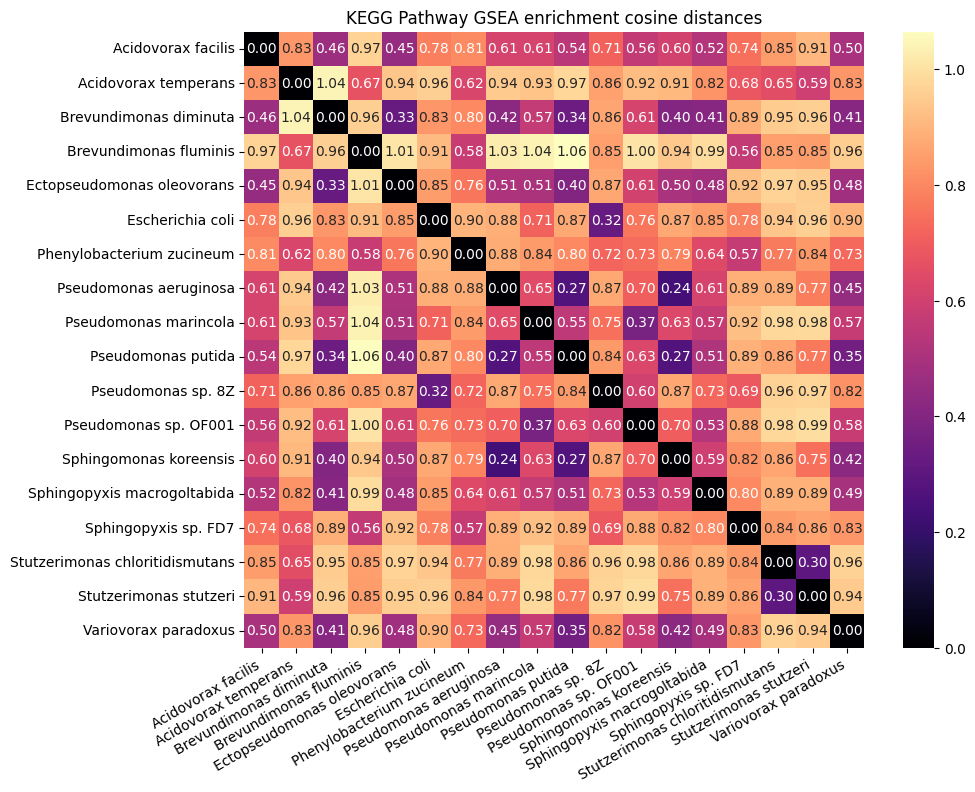

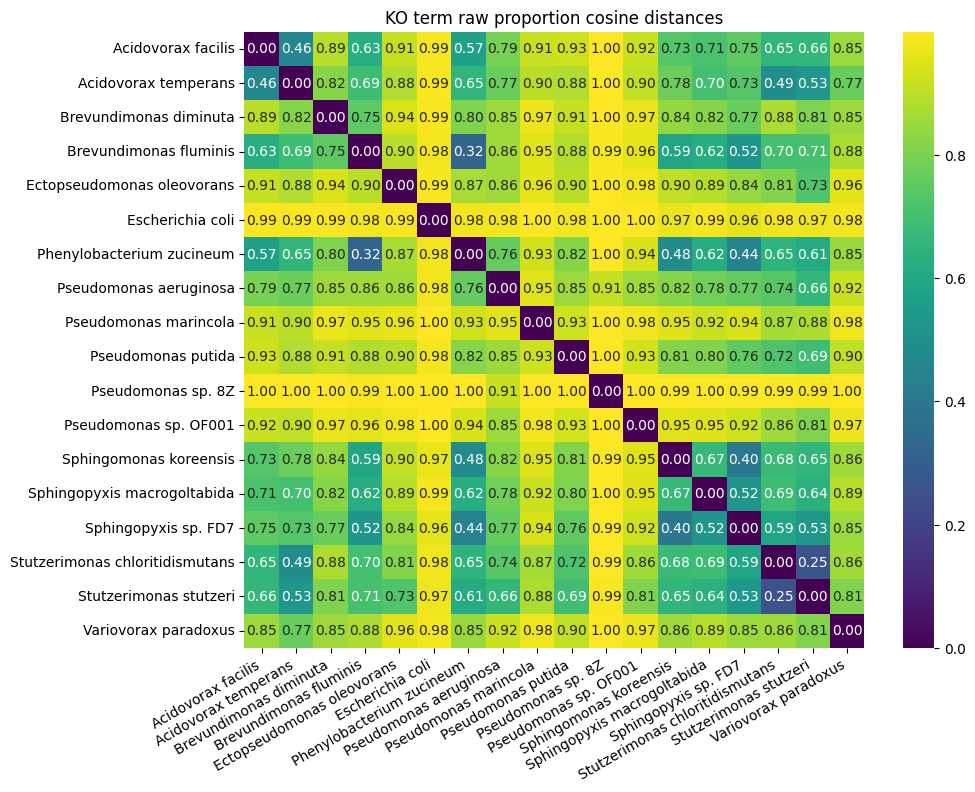

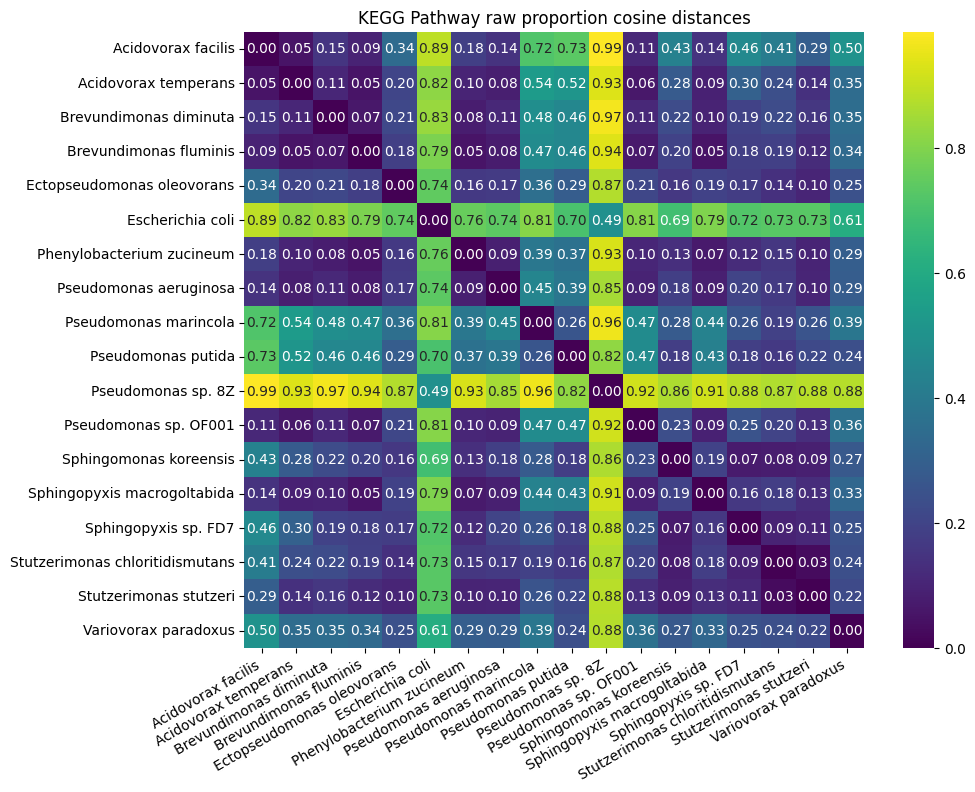

In [ ]:
#similarity between species based off of functional terms
raw_ko_gsea, dist_ko_gsea = func_utils.plot_heatmap(ko_gsea_path, 'KO term GSEA enrichment cosine distances', 'pathway', 'gsea', 'magma')
raw_kp_gsea, dist_kp_gsea = func_utils.plot_heatmap(path_gsea_path, 'KEGG Pathway GSEA enrichment cosine distances', 'pathway', 'gsea', 'magma')
raw_ko_rc, dist_ko_rc = func_utils.plot_heatmap(ko_raw_path, 'KO term raw proportion cosine distances', 'KO_Name', 'proportions', 'viridis')
raw_kp_rc, dist_kp_rc = func_utils.plot_heatmap(pathway_raw_path, 'KEGG Pathway raw proportion cosine distances', 'Pathway_Name', 'proportions', 'viridis')

In [ ]:
#Raw proportions displayed more shared functions compared to GSEA, 
#so we will use raw counts for downstream analysis. 

rc_dis_mats = [(dist_ko_rc, 'KO term raw proportion cosine distances'),
                (dist_kp_rc, 'KEGG Pathway raw proportion cosine distances')]
rc_proportion_mats = [
    (raw_ko_rc, 'KO term raw proportions'),
    (raw_kp_rc, 'KEGG Pathway raw proportions')
]

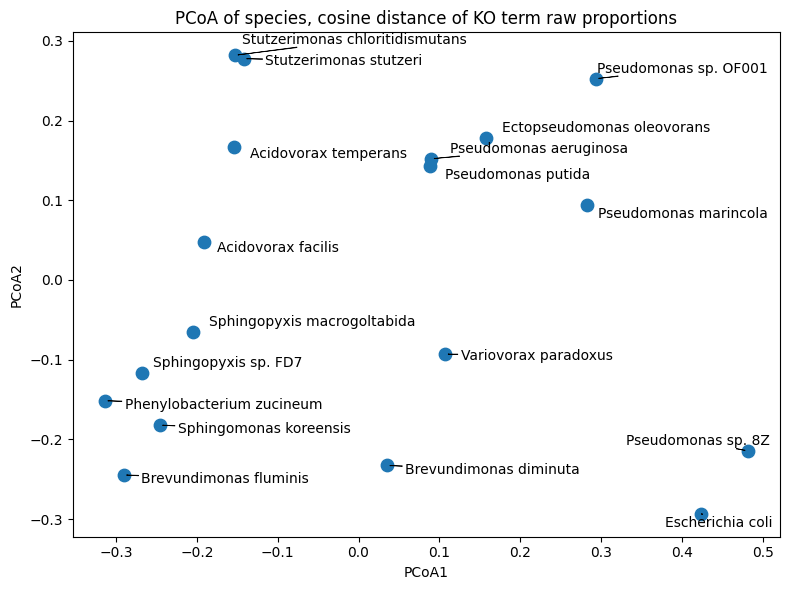

C:\Users\yoche\miniconda3\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.10004618077472925 whereas the largest positive one is 1.159127976698389.
  warn(


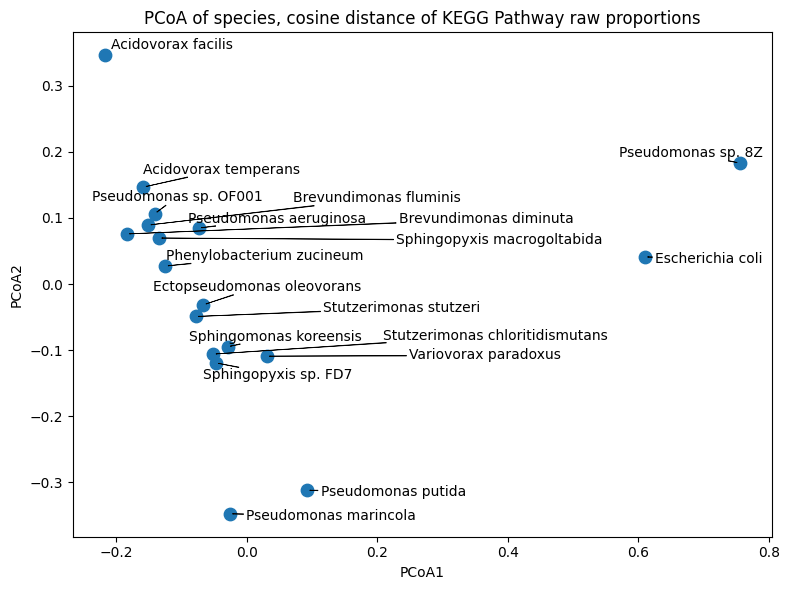

In [ ]:
#PCoA visualization of species similarity
for mat, title in rc_dis_mats:
    mat.fillna(0.0, inplace=True)
    np.fill_diagonal(mat.values, 0)
    mat = (mat + mat.T) / 2
    func_utils.pcoa_plot(mat, title)

## Functional Term Enrichment

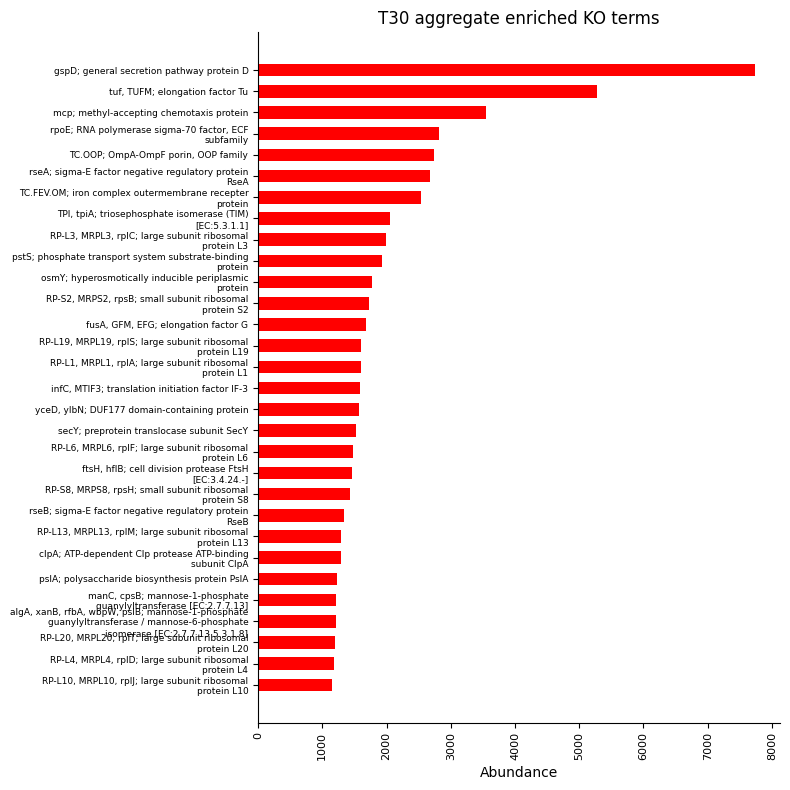

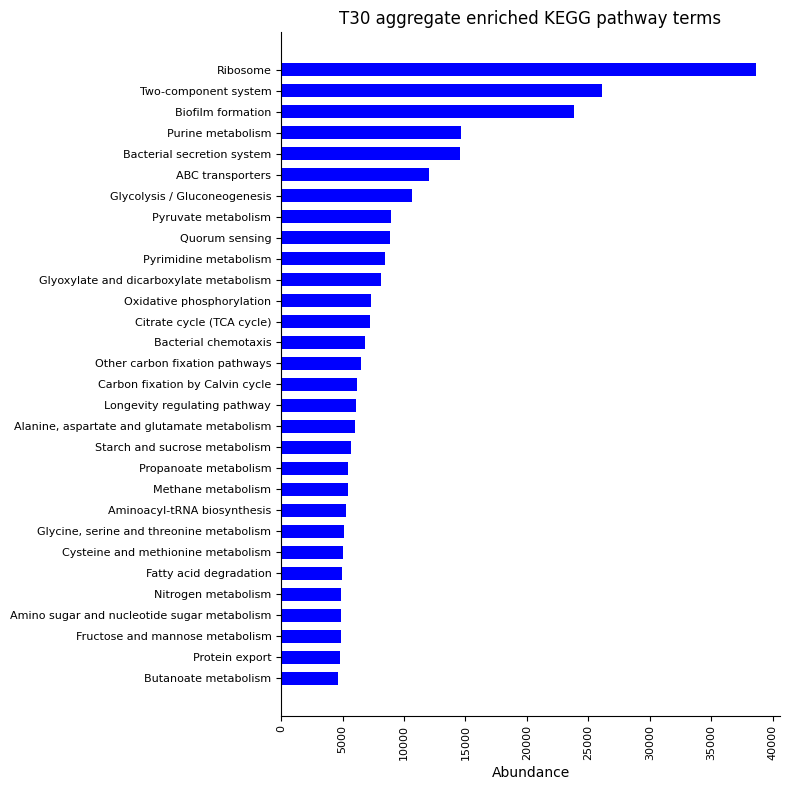

In [ ]:
#top 30 KO terms and KEGG pathways, based off of raw abundance aggregated from all species
func_utils.plot_rawct_enrichment(ko_counts_df, 30, 'KO_terms', 'red', fontsize = 6.5)
func_utils.plot_rawct_enrichment(path_counts_df, 30, 'KEGG_pathway_terms', 'blue')

Saving plot to: figures\functional_analysis\kegg_pathway_t30_abundance_stacked.png


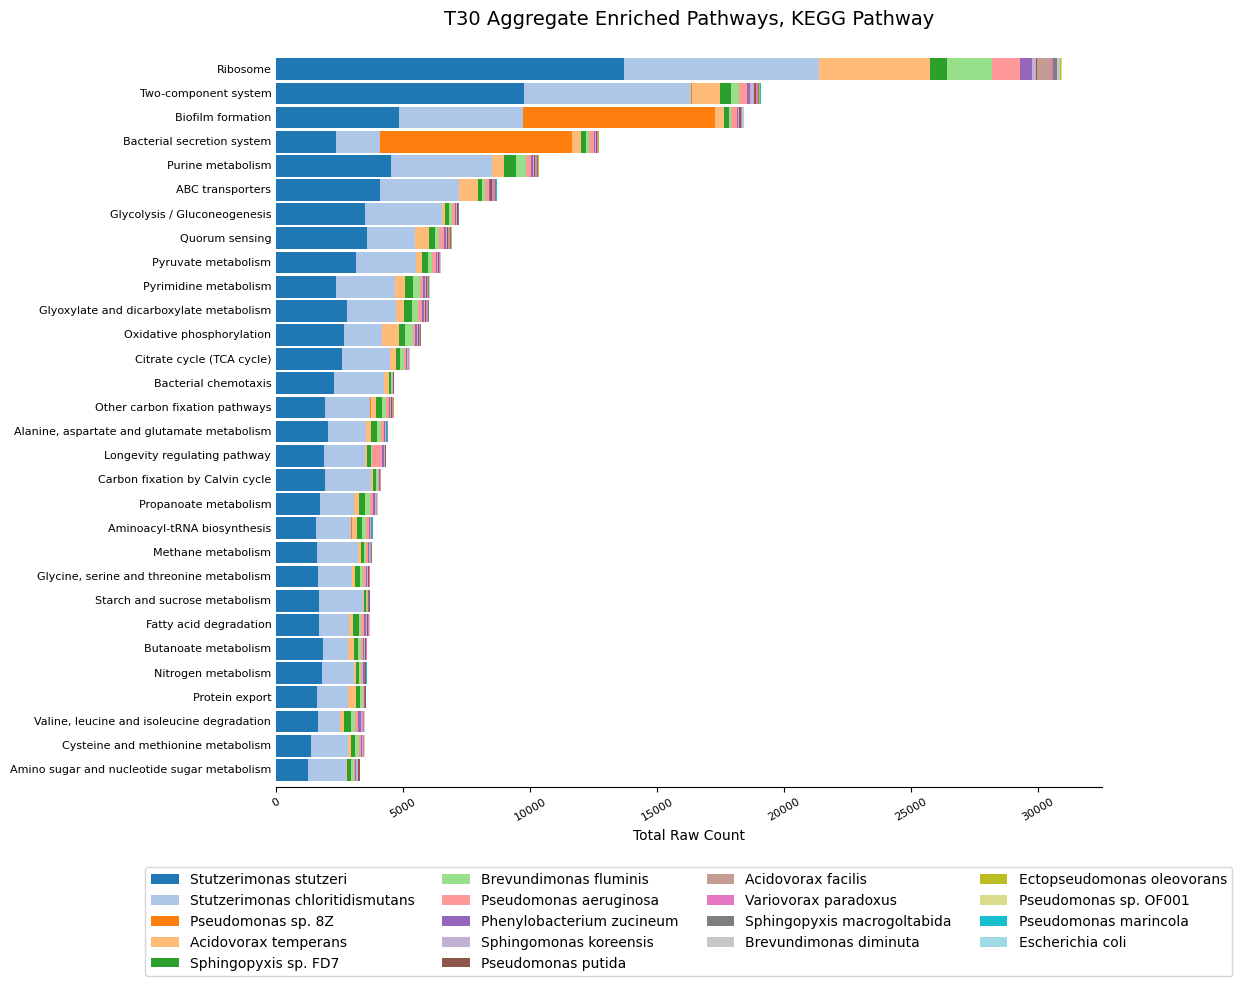

Saving plot to: figures\functional_analysis\ko_terms_t30_abundance_stacked.png


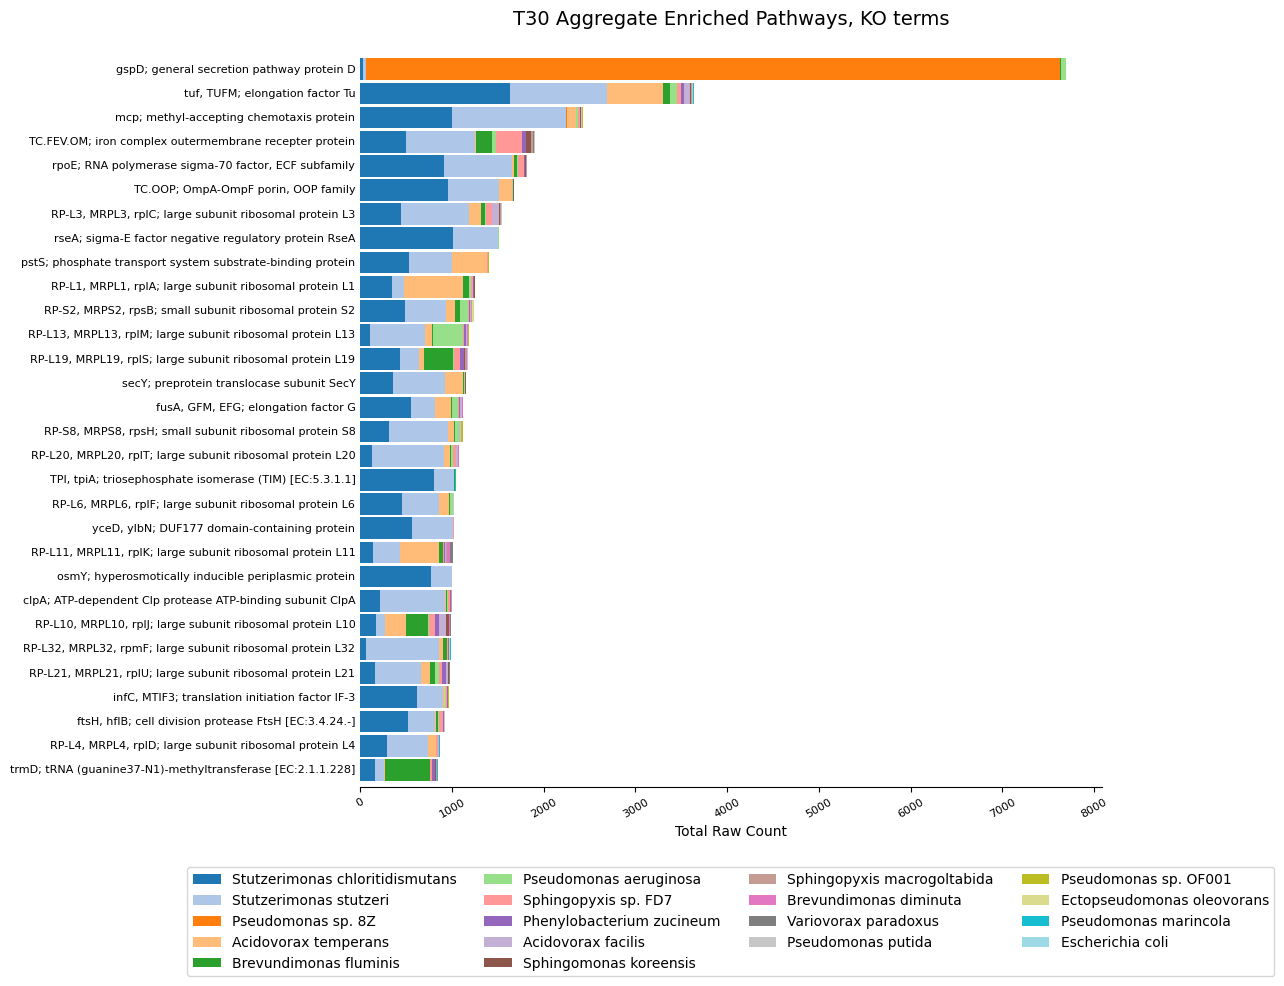

In [ ]:
#same thing but with species contribution visualized
func_utils.plot_top_pathway_abundance(30, 'KEGG_Pathway', 'kp', fontsize=8)
func_utils.plot_top_pathway_abundance(30, 'KO_terms', 'ko', fontsize=8)


Top 10 median scores:
pathway
Choline metabolism in cancer               0.362560
Phospholipase D signaling pathway          0.362560
Prion disease                              0.355045
Ribosome                                   0.243413
Arachidonic acid metabolism                0.127432
Proteoglycans in cancer                    0.082205
Primary immunodeficiency                   0.069926
Biosynthesis of terpenoids and steroids    0.065146
Thyroid hormone synthesis                  0.048837
Ribosome biogenesis in eukaryotes          0.020588
Name: 0.5, dtype: float64

Top 10 prevalence scores:
pathway
Ribosome                                  15
Photosynthesis                             8
Platinum drug resistance                   7
Pathways in cancer                         7
Fluid shear stress and atherosclerosis     7
Chemical carcinogenesis - DNA adducts      6
Drug metabolism - other enzymes            6
Huntington disease                         6
Hepatocellular carcinoma    

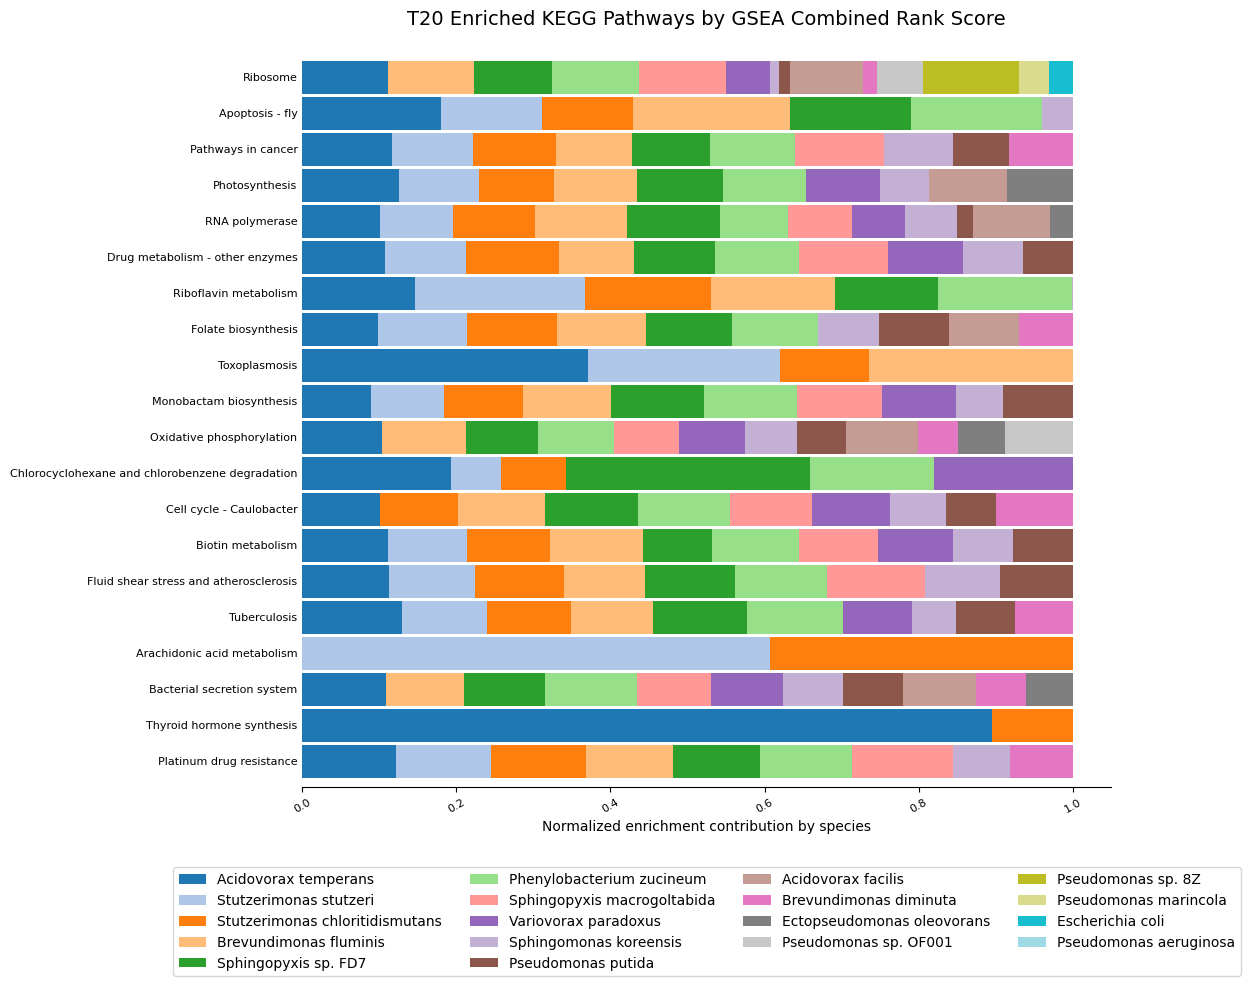


Top 10 median scores:
ko_term
priB; primosomal replication protein N                       0.448529
flp, pilA; pilus assembly protein Flp/PilA                   0.441479
RP-L31, rpmE; large subunit ribosomal protein L31            0.421105
napE; periplasmic nitrate reductase NapE                     0.419095
RP-L27, MRPL27, rpmA; large subunit ribosomal protein L27    0.418324
hns; DNA-binding protein H-NS                                0.417817
K06884; uncharacterized protein                              0.417811
flhD; flagellar transcriptional activator FlhD               0.409097
ccmD; heme exporter protein D                                0.404669
rmf; ribosome modulation factor                              0.404297
Name: 0.5, dtype: float64

Top 10 prevalence scores:
ko_term
rpoE; RNA polymerase sigma-70 factor, ECF subfamily          7
GST, gst; glutathione S-transferase [EC:2.5.1.18]            6
RP-L19, MRPL19, rplS; large subunit ribosomal protein L19    5
RP-L10, MRPL10, rpl

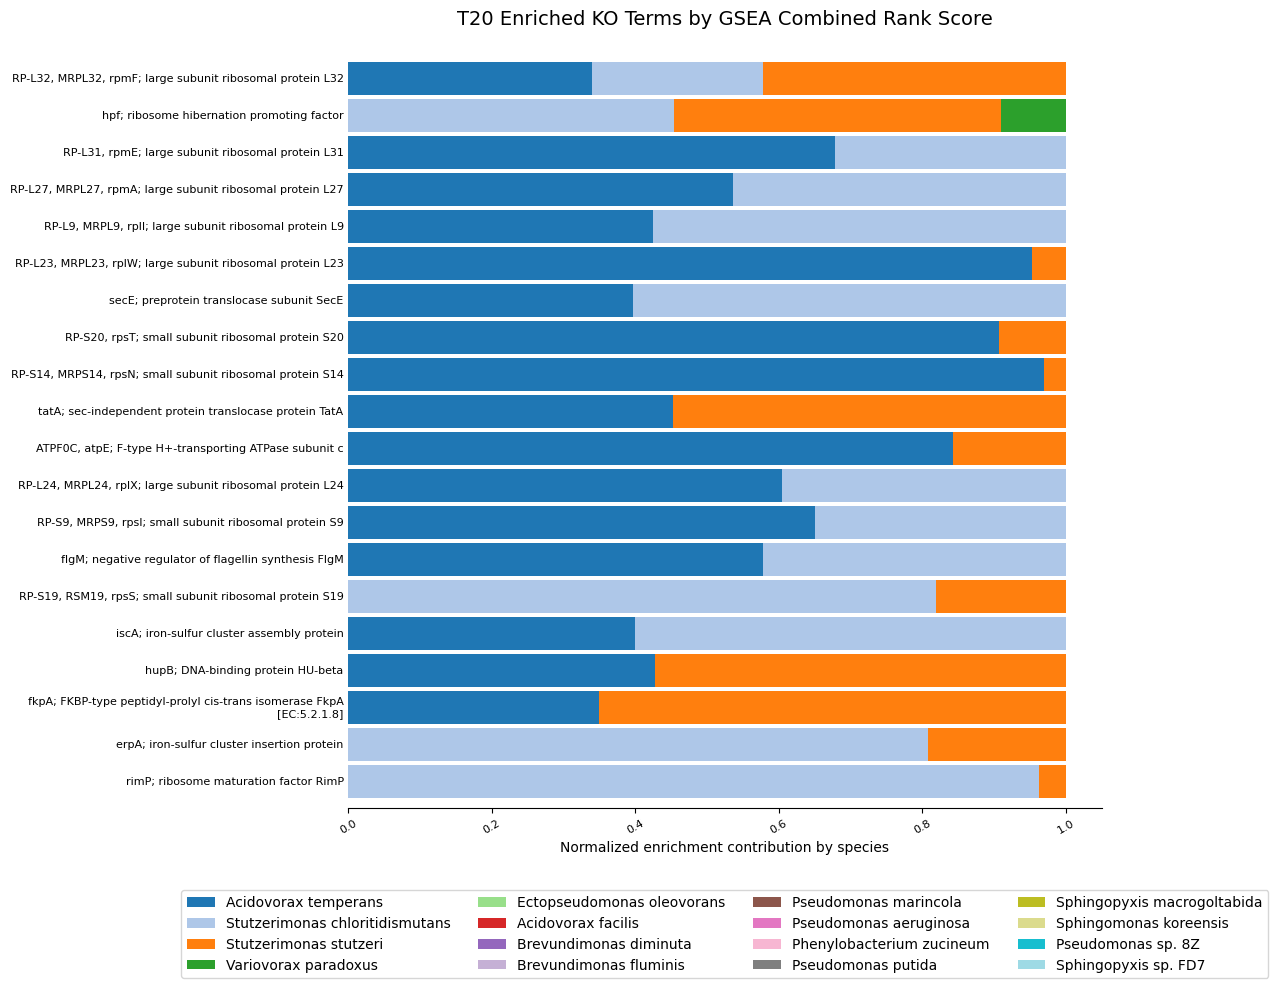

In [ ]:
#calculate and plot aggregate GSEA scores (more details in functional_analysis_tools.py script)
func_utils.analyze_and_plot_gsea(analysis_type='kp', top_n=20)
func_utils.analyze_and_plot_gsea(analysis_type='ko', top_n=20, fontsize=8)